In [75]:
from helpers_merging import *

initial_power = 50* si.uW
initial_waist = 1.1*si.uW
initial_distance = 3*si.um

trap: DoubleTweezer = DoubleTweezer(
    power=0,  # Set pancake laser power to 0, no 2D trap
    grad_z= 0*si.G/si.cm,
    grad_r=0,
    power_tweezer1 = initial_power,     #stationary
    power_tweezer2 = initial_power,     #transfer tweezer
    waist_tweezer1 = initial_waist,     #stationary
    waist_tweezer2 = initial_waist*1.02,     #transfer tweezer
    distance_tweezers = initial_distance,

    a=180*(4 * np.pi * const.epsilon_0 * const.value("Bohr radius")**3)/(2 * const.epsilon_0 * const.c),
    wvl = 532 * si.nm,

    g = 0,
)

x, y, z = trap.x, trap.y, trap.z

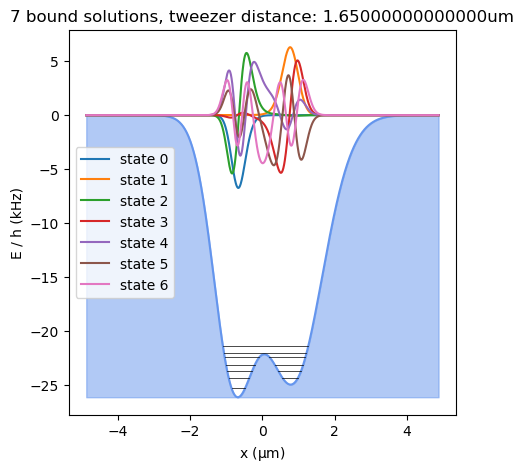

In [76]:
left_cutoff = -0.5*initial_distance-3*np.max([float(trap.subs(trap.waist_tweezer1)),float(trap.subs(trap.waist_tweezer2))])
right_cutoff = 0.5*initial_distance+3*np.max([float(trap.subs(trap.waist_tweezer1)),float(trap.subs(trap.waist_tweezer2))])

trap[trap.distance_tweezers] = 0.55*initial_distance
trap[trap.power_tweezer2] = initial_power*2.5
trap[trap.waist_tweezer2] = initial_waist*1.5
plot_solutions(trap,7,left_cutoff,right_cutoff,display_plot=-1,state_mult=40,n_pot_steps=1000,plot=True,ret_results=False)

In [89]:
def get_deltaE_occ(power_tweezer1, power_tweezer2, waist_tweezer1, waist_tweezer2,
               n_levels=10,n_pot_steps=2000, initial_distance=4*si.um):
    """
    Returns the minimal energy gap and occupation numbers of the groundstate when the two tweezers merge.
    """
    trap[trap.power_tweezer1] = power_tweezer1
    trap[trap.power_tweezer2] = power_tweezer2
    trap[trap.waist_tweezer1] = waist_tweezer1
    trap[trap.waist_tweezer2] = waist_tweezer2

    distances = np.linspace(initial_distance,0*si.um,500) #always has to have smallest distance at last index
    energies, states, potentials = loop_distances(trap, distances,n_levels=n_levels,n_pot_steps=n_pot_steps)

    new_energies, new_states, new_potentials, index_top, index, swap_index = swapped_loop_distance(distances, energies, states, potentials)
    energies_left, energies_right, states_left, states_right,deltaE_min, occ_num = find_ass_tweezer(new_energies,new_states)
    print(index)

    # Create the figure with two subplots (1 row, 2 columns)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

    # Plot the full range on ax1
    """
    ax1.plot(distances/si.um, energies_left[:, 0], color="red", label="GS left tweezer")
    ax1.plot(distances/si.um, energies_right[:, 0], color="blue", label="GS right tweezer")
    ax1.plot(distances/si.um, energies_left[:, 1:], color="red", linestyle="dotted", label="left tweezer")
    ax1.plot(distances/si.um, energies_right[:, 1:], color="blue", linestyle="dotted", label="right tweezer")"""
    ax1.plot(distances/si.um, energies_left[:], color="red", label="left tweezer")
    ax1.plot(distances/si.um, energies_right[:], color="blue", label="right tweezer")

    for i, ind in enumerate(index):
        ax1.axvline(distances[ind]/si.um, color="k", alpha=0.7, label="energy crossings")

    ax1.set_xlabel("Tweezer distance [um]")
    ax1.set_ylabel("Eigenenergy [a.u.]")
    ax1.set_title(fr"$p_l={float(trap.subs(trap.power_tweezer1))/si.uW:.1f}$ uW, $p_r={float(trap.subs(trap.power_tweezer2))/si.uW:.1f}$ uW, $w_l={float(trap.subs(trap.waist_tweezer1))/si.um:.3f}$ um, $w_r={float(trap.subs(trap.waist_tweezer2))/si.um:.3f}$ um")
    ax1.grid()

    # Plot the zoomed-in range (1 to 1.5 µm) on ax2
    """
    ax2.plot(distances/si.um, energies_left[:, 0], color="red", label="GS left tweezer")
    ax2.plot(distances/si.um, energies_right[:, 0], color="blue", label="GS right tweezer")
    ax2.plot(distances/si.um, energies_left[:, 1:], color="red", linestyle="dotted", label="left tweezer")
    ax2.plot(distances/si.um, energies_right[:, 1:], color="blue", linestyle="dotted", label="right tweezer")"""
    ax2.plot(distances/si.um, energies_left[:], color="red", label="left tweezer")
    ax2.plot(distances/si.um, energies_right[:], color="blue", label="right tweezer")

    for i, ind in enumerate(index):
        ax2.axvline(distances[ind]/si.um, color="k", alpha=0.7, label="energy crossings")

    ax2.set_xlabel("Tweezer distance [um]")
    ax2.set_ylabel("Eigenenergy [a.u.]")
    ax2.set_title("Zoomed-in Region")
    ax2.set_xlim(1.2, 2)  # Zooming in on the region between 1.0 and 1.5 µm
    ax2.set_ylim(-2e-29,-0.5e-29)
    ax2.grid()

    # Remove duplicates in the legend (labels that appear in both subplots)
    handles, labels = ax1.get_legend_handles_labels()
    unique_labels = dict(zip(labels, handles))  # Remove duplicates
    ax1.legend(unique_labels.values(), unique_labels.keys())

    # Show the plots
    plt.tight_layout()
    plt.show()

    return deltaE_min, occ_num

[210 251]


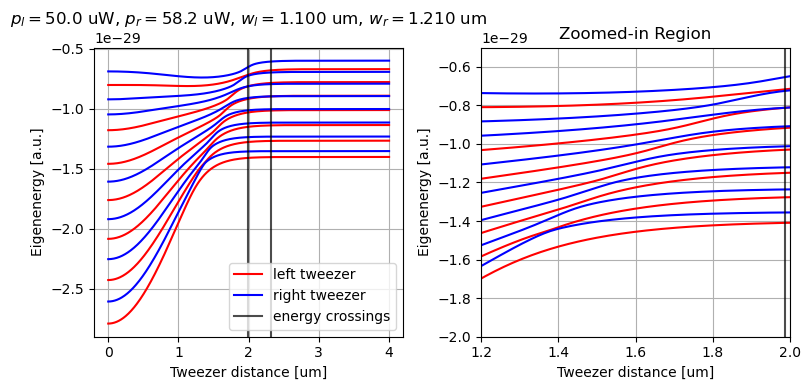

In [92]:
factor_waist2 = 1.1

trap[trap.power_tweezer1] = initial_power
trap[trap.waist_tweezer1] = initial_waist
trap[trap.waist_tweezer2] = initial_waist*factor_waist2

omega_r1 = sp.sqrt(2*trap.power_tweezer1*trap.a/sp.pi/trap.m)*2/trap.waist_tweezer1**2
omega_r2 = sp.sqrt(2*trap.power_tweezer2*trap.a/sp.pi/trap.m)*2/trap.waist_tweezer2**2

#offset required for 1 level spacing of the left tweezer
power2_offset = sp.pi*trap.waist_tweezer2**2*const.hbar*omega_r1/2/trap.a

#factor to match trap depth and offset by half the level spacing
power2_factor = factor_waist2**2 - 0.4*float(trap.subs(power2_offset))/initial_power

deltaEs, occ_numbers = get_deltaE_occ(initial_power,initial_power*power2_factor,initial_waist,initial_waist*factor_waist2,n_levels=15)

--------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

[390 392]


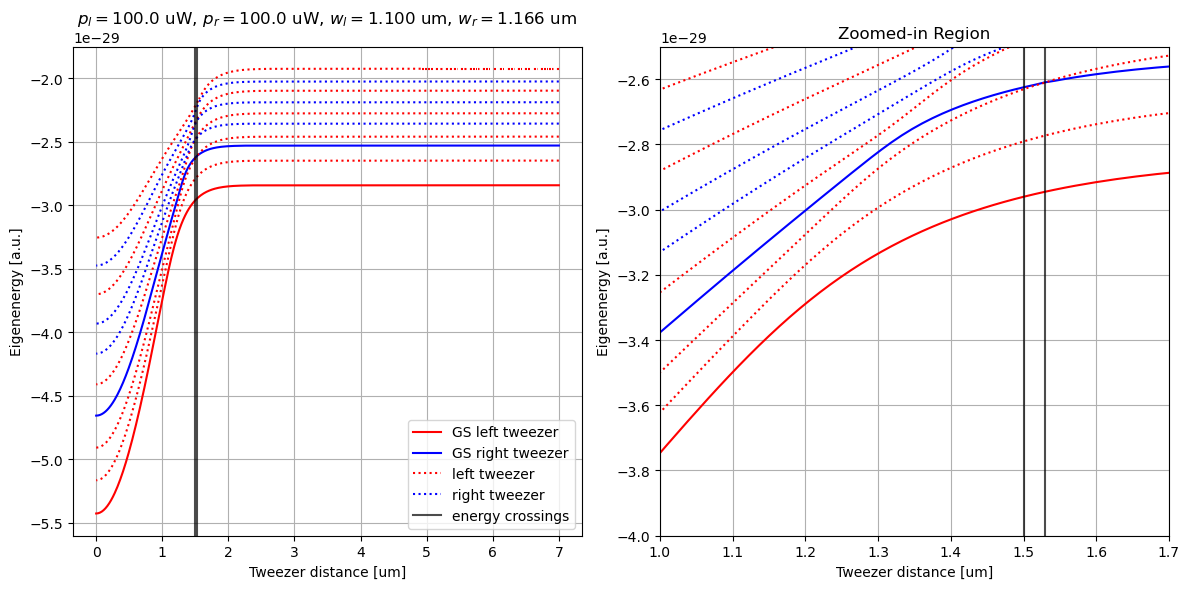

 10%|█         | 1/10 [00:36<05:24, 36.02s/it]

[400]


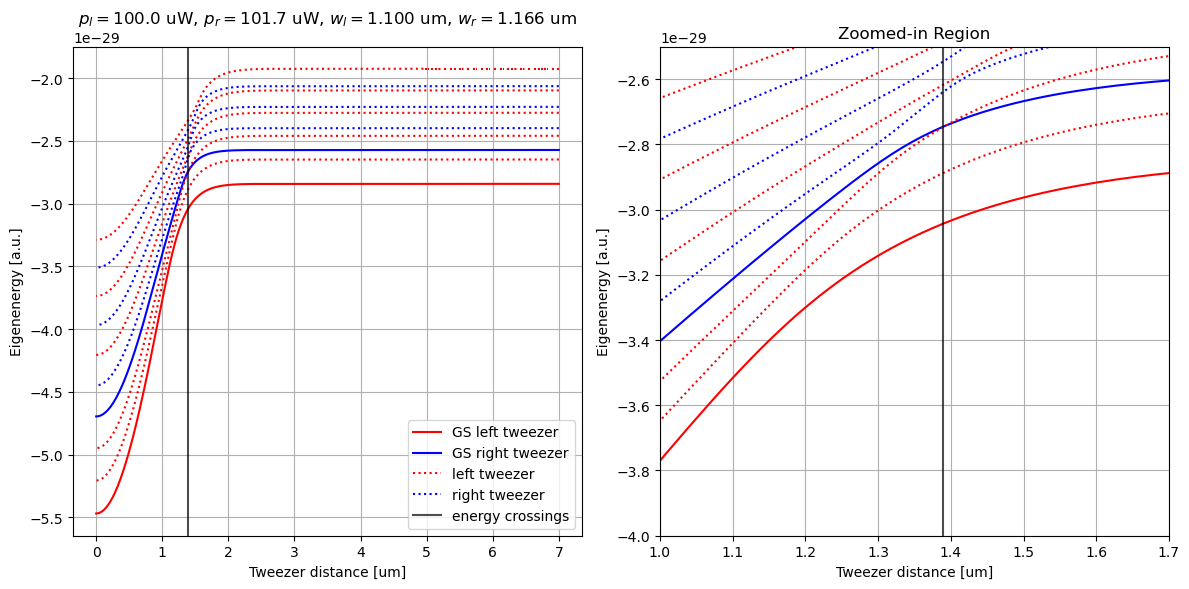

 20%|██        | 2/10 [01:12<04:50, 36.29s/it]

[343]


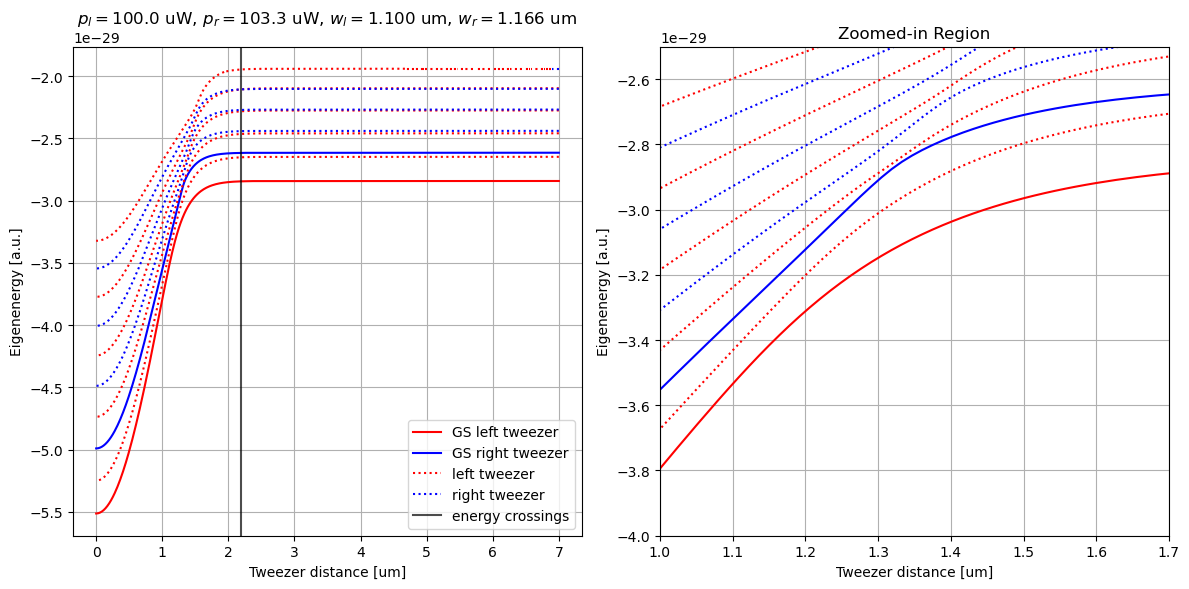

 30%|███       | 3/10 [01:47<04:10, 35.84s/it]

[362 372 378 381]


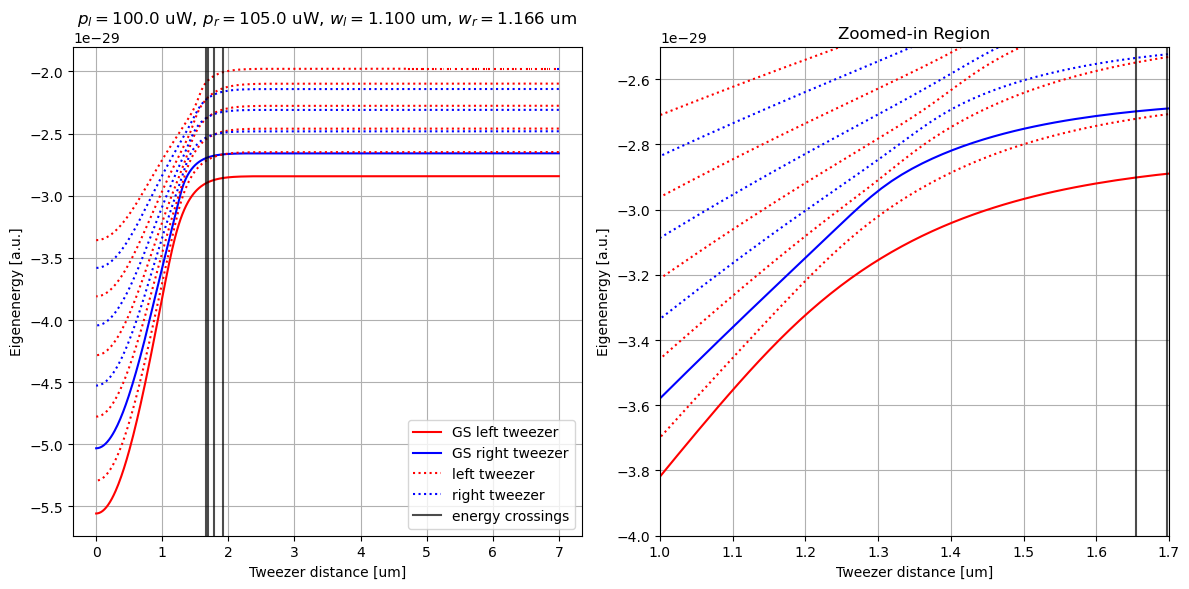

 40%|████      | 4/10 [02:23<03:33, 35.62s/it]

[389 391]


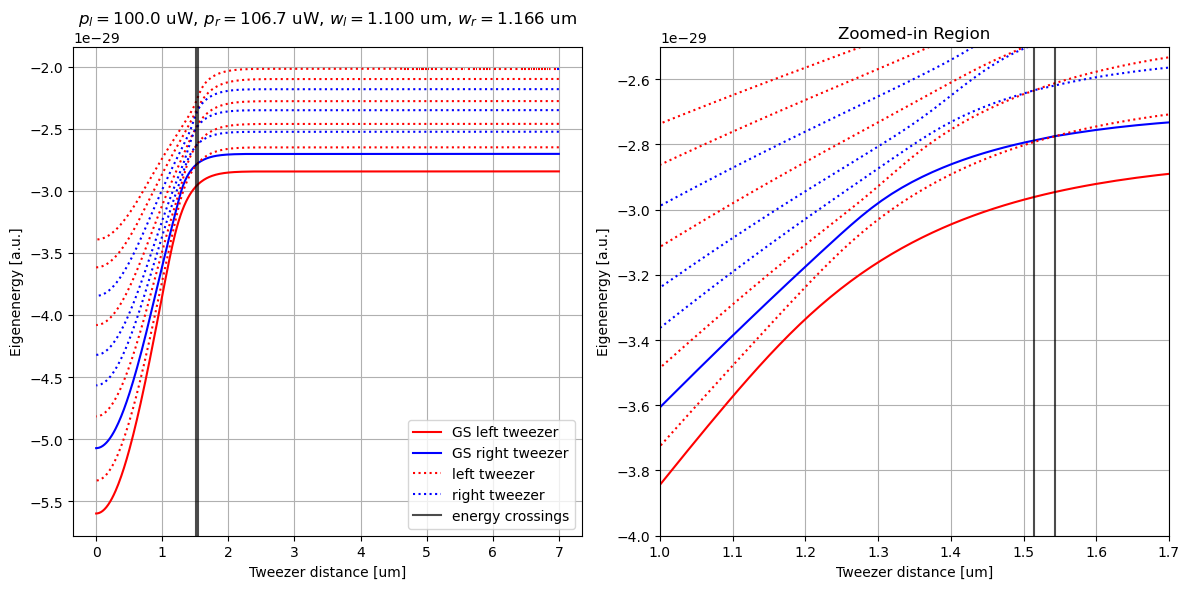

 50%|█████     | 5/10 [02:58<02:58, 35.66s/it]

[401]


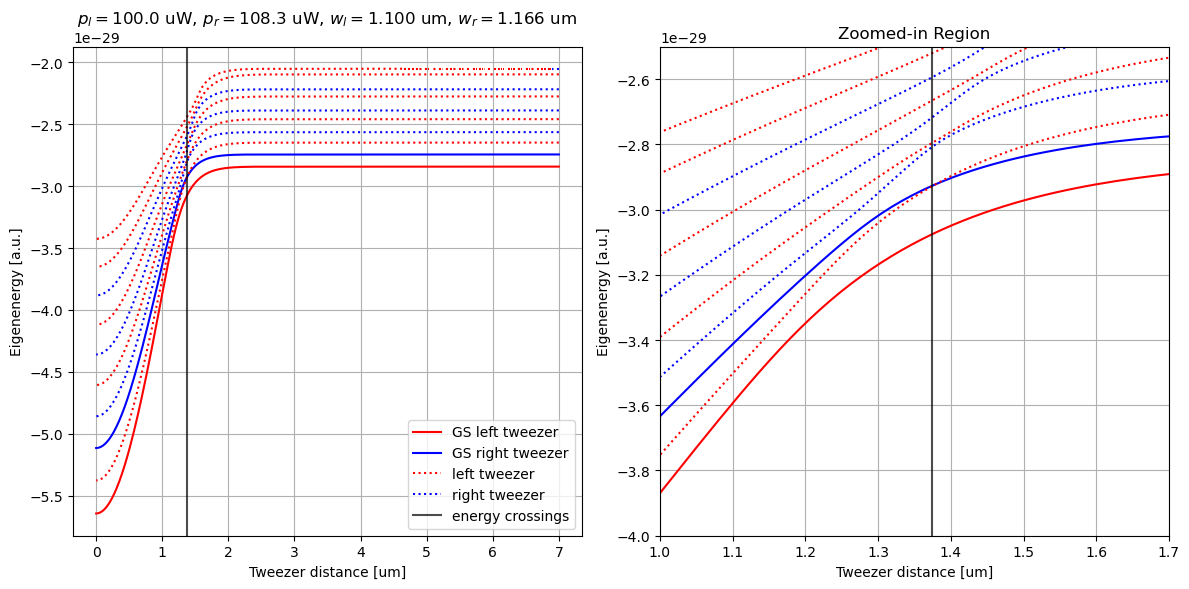

 60%|██████    | 6/10 [03:34<02:23, 35.78s/it]

[]


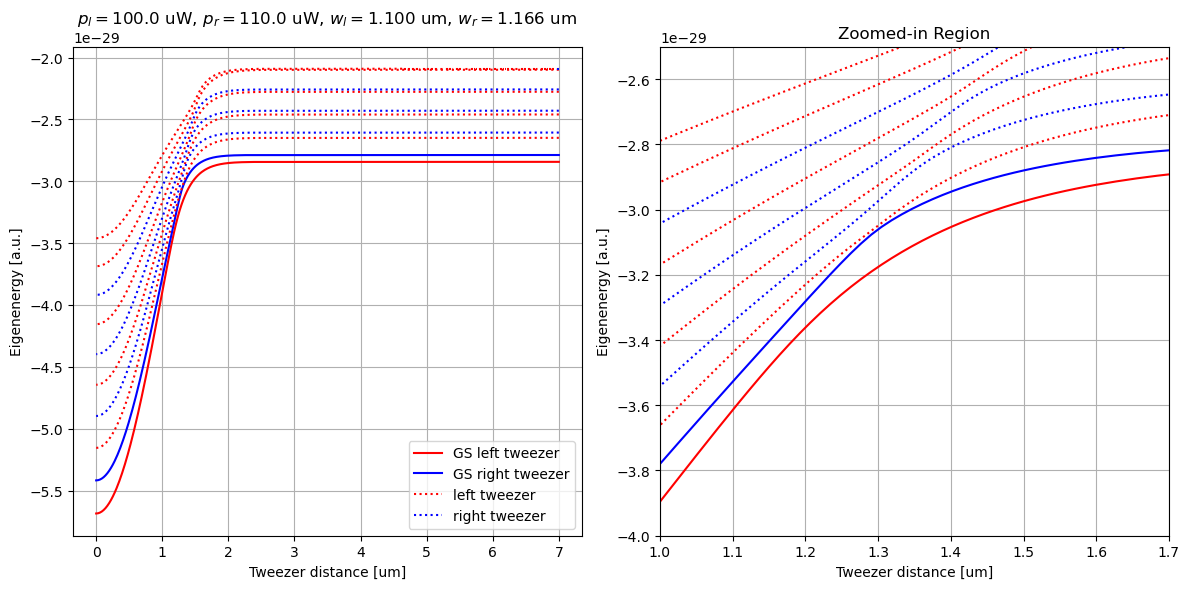

 70%|███████   | 7/10 [04:11<01:47, 35.96s/it]

[  1   7  10  12  15  18  22  27  29  31  36  40  43  46  48  52  60  62
  65  68  72  76  79  83  87  89  91  93  96  99 104 107 111 114 119 123
 127 130 135 138 142 145 362 372 377]


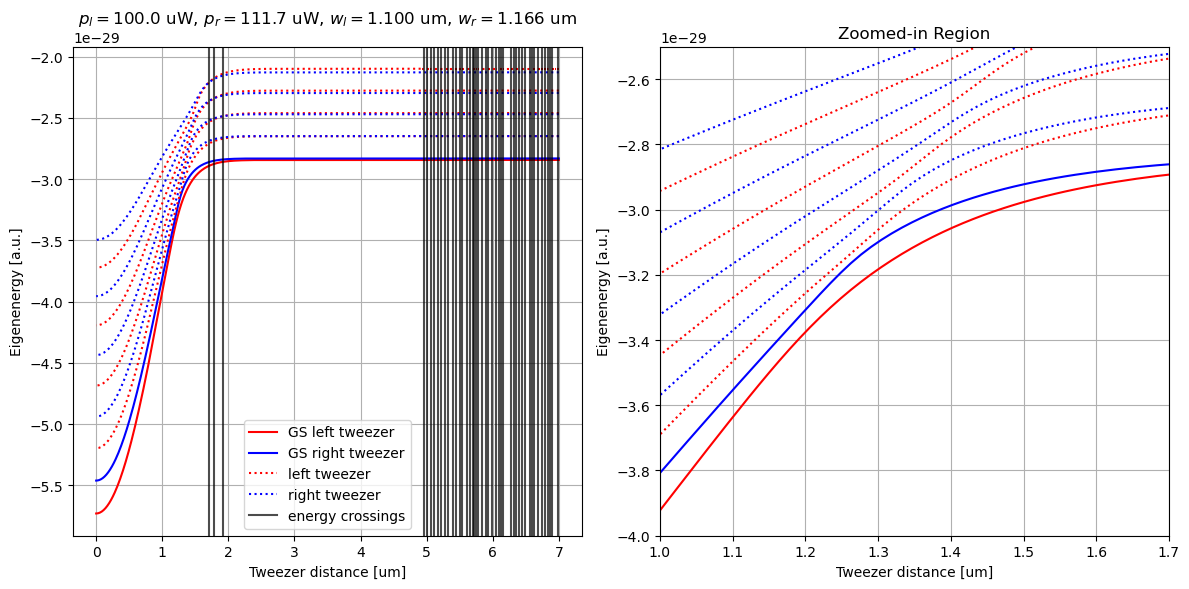

 80%|████████  | 8/10 [04:49<01:13, 36.71s/it]

[385 388 391]


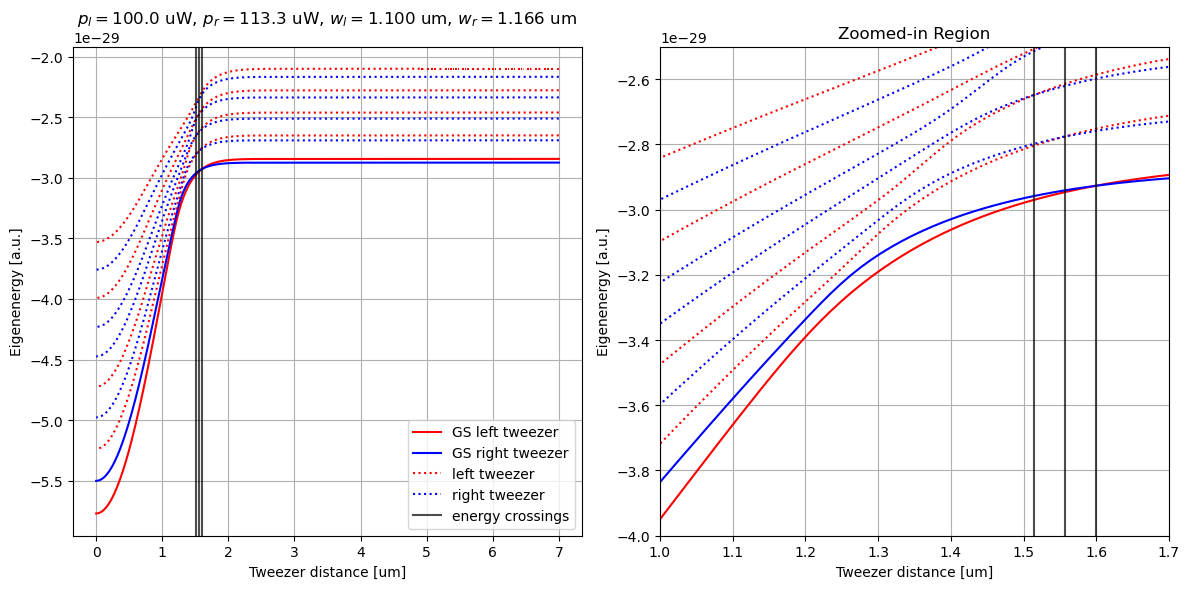

 90%|█████████ | 9/10 [05:27<00:37, 37.11s/it]

[401]


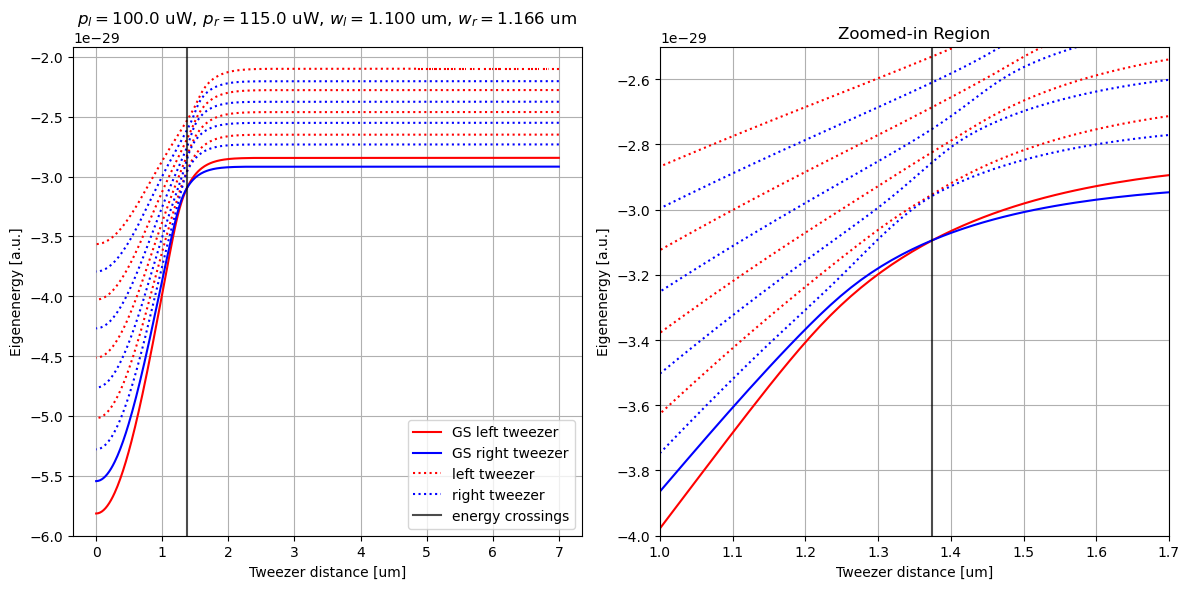

100%|██████████| 10/10 [06:06<00:00, 36.67s/it]


In [6]:
factor_waist2 = 1.06

power2_factors = np.linspace(1+1e-5,1.15,10)
deltaEs = np.zeros_like(power2_factors)
occ_numbers = np.zeros((len(power2_factors),2))

for i, pow in enumerate(tqdm(power2_factors)):
    deltaEs[i], occ_numbers[i] = get_deltaE_occ(initial_power,initial_power*pow,initial_waist,initial_waist*factor_waist2)

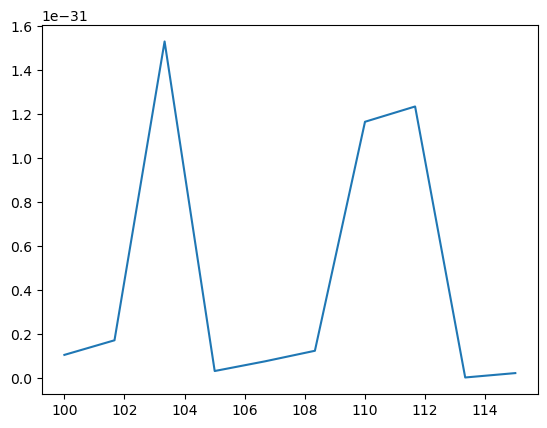

In [7]:
plt.plot(initial_power*power2_factors/si.uW, deltaEs)

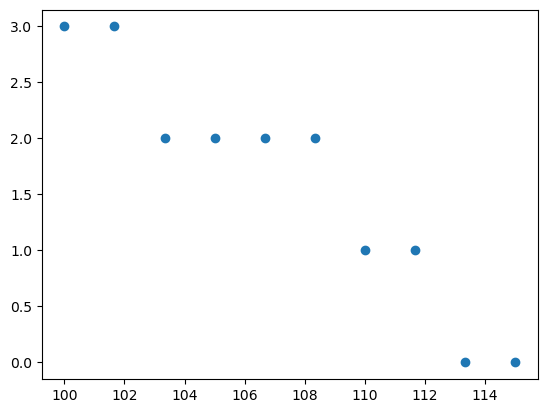

In [8]:
plt.plot(initial_power*power2_factors/si.uW, occ_numbers[:,1],"o")

----------------

In [9]:
from scipy.optimize import minimize

[]


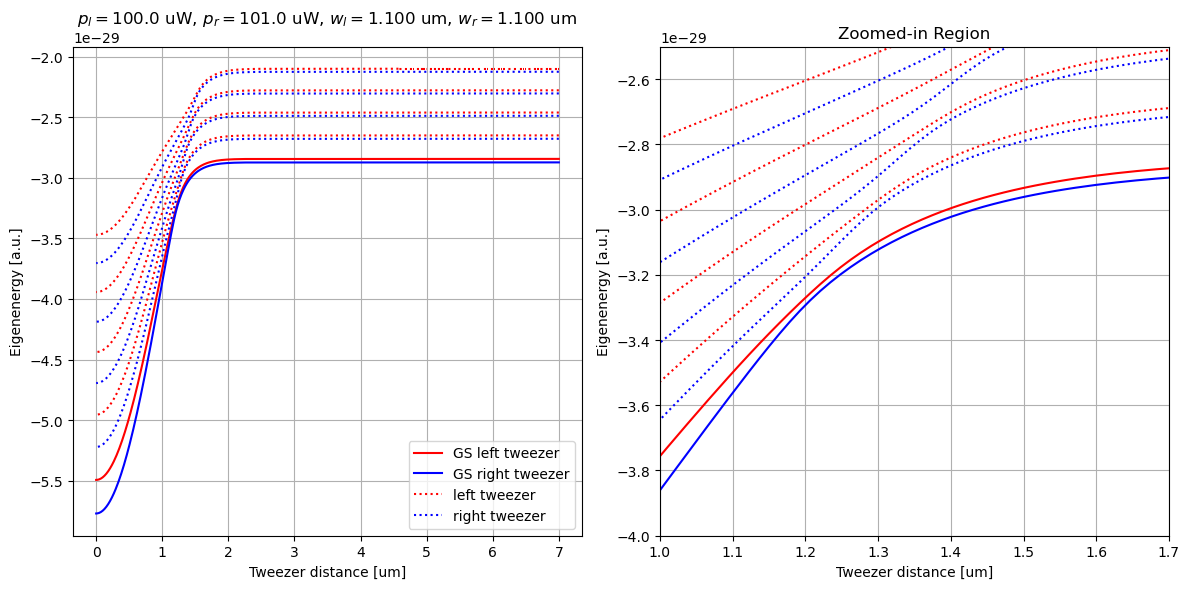

[]


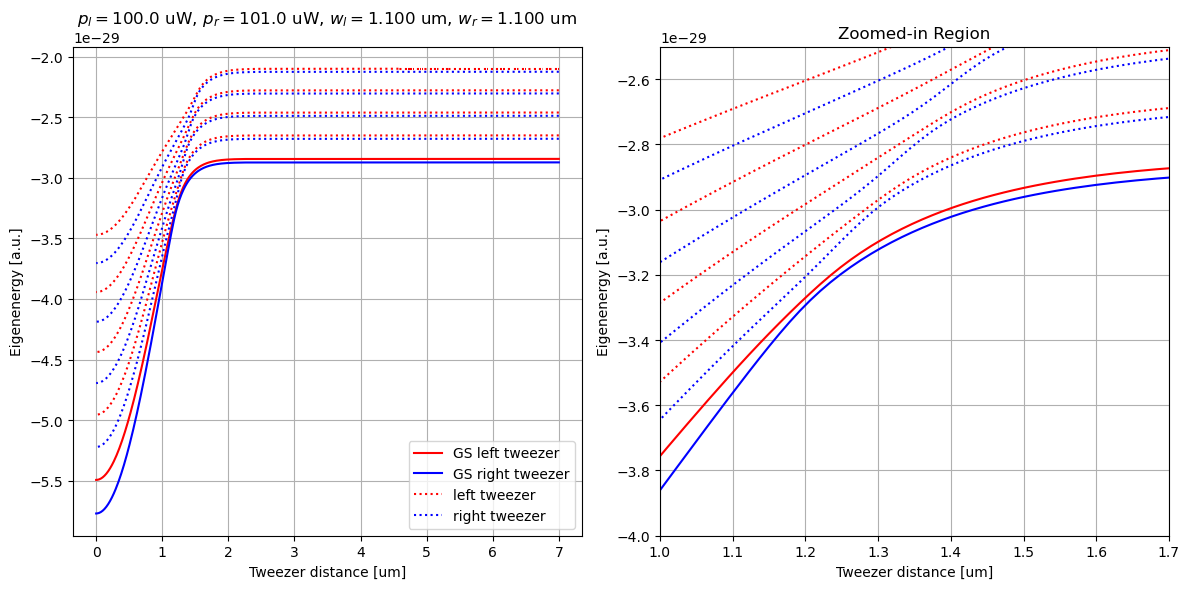

[]


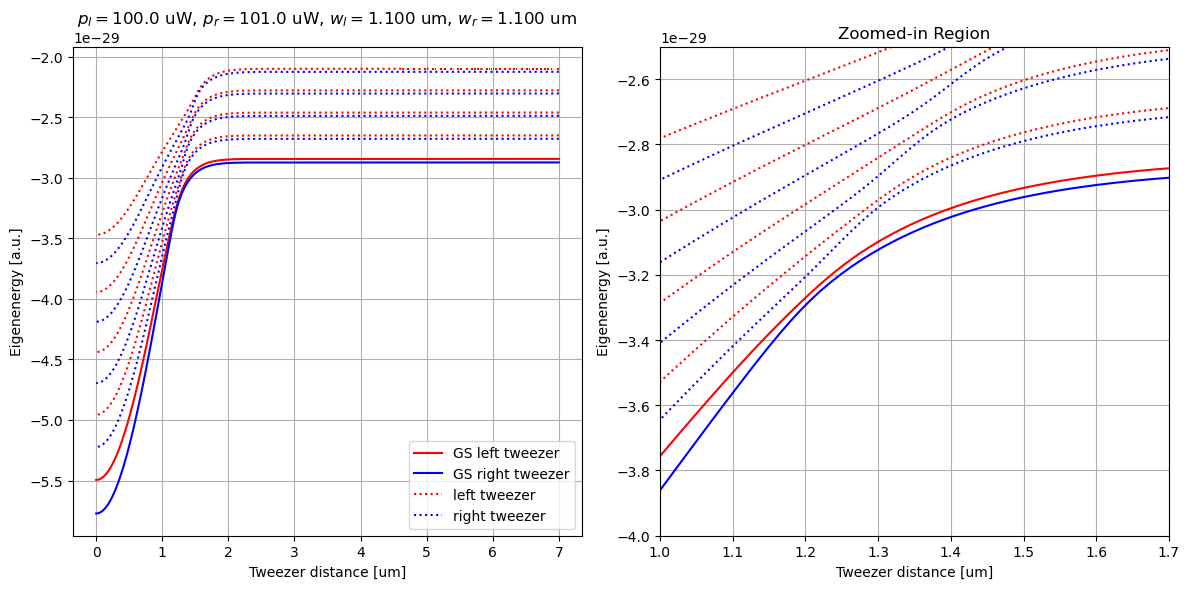

[]


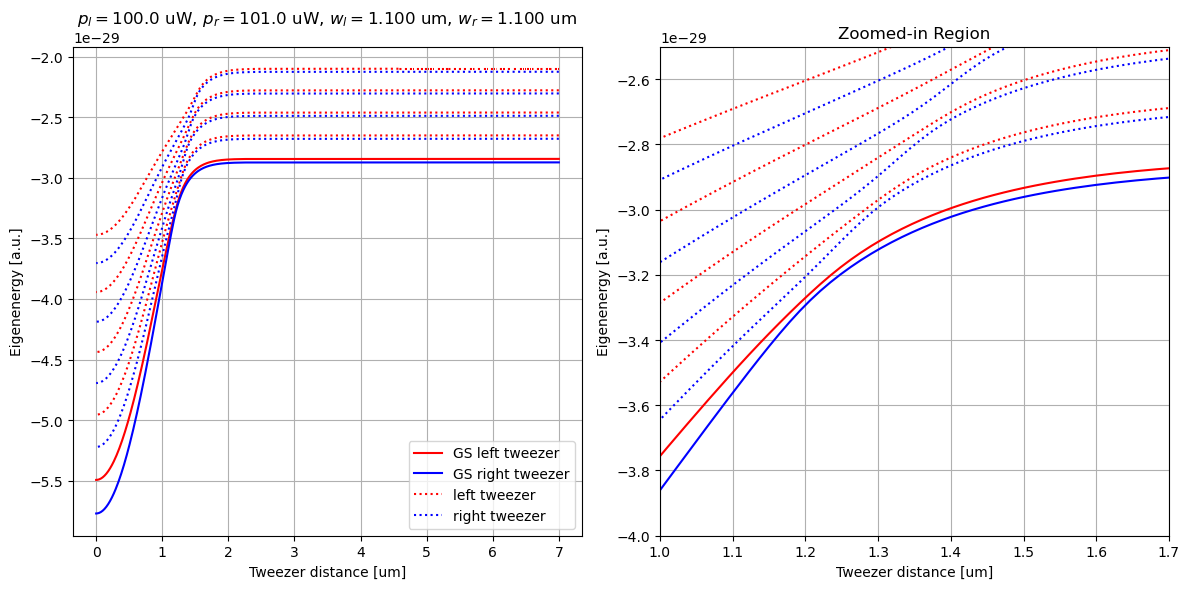

[]


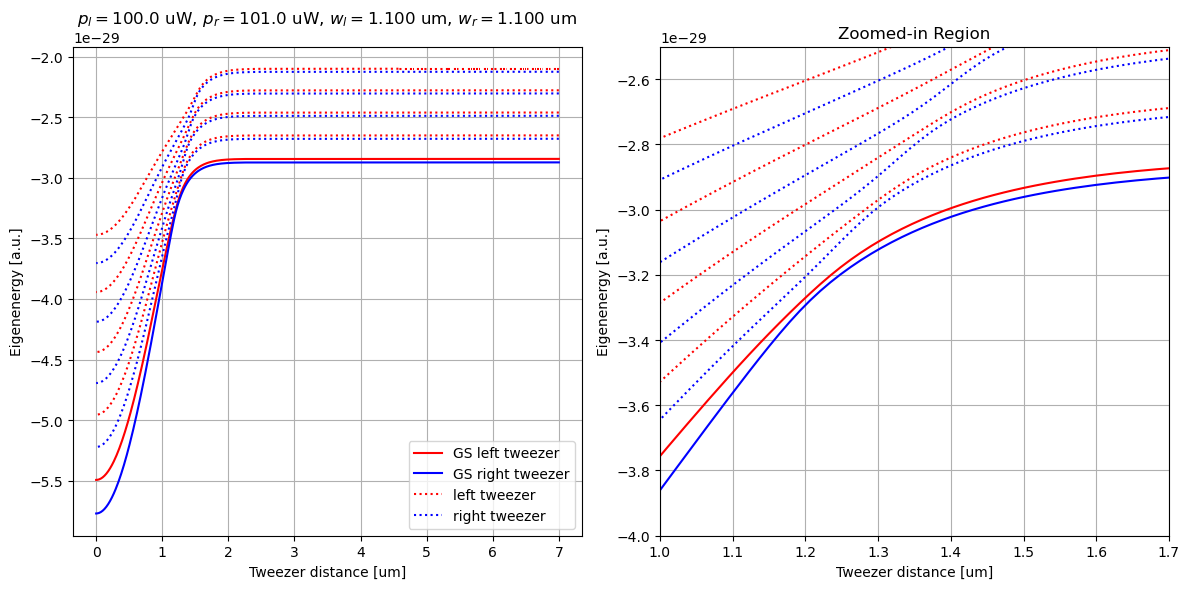

[]


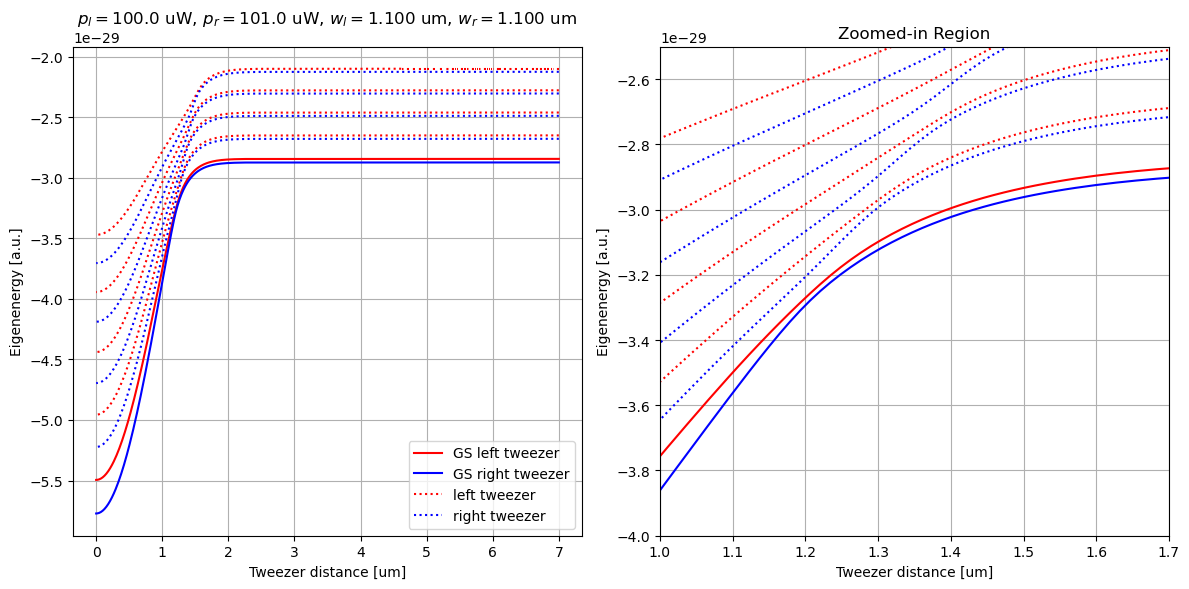

In [10]:
factor_waist2 = 1.

def objective(x):
    """function to minimise"""
    deltaE_min, occ_num = get_deltaE_occ(initial_power,x[0],initial_waist,initial_waist*factor_waist2)

    return -deltaE_min *1e32

def constraint(x):
    """contraint for minimisation"""
    deltaE_min, occ_num = get_deltaE_occ(initial_power,x[0],initial_waist,initial_waist*factor_waist2)

    return occ_num[1] -1

x0 = initial_power*1.01
bou = [(initial_power, 2*initial_power)]
con = {"type":"eq", "fun":constraint}

result = minimize(objective, x0, bounds=bou, constraints=con)

In [11]:
print("Optimal solution:", result.x)
print("Objective value at optimal solution:", result.fun)
print("Success:", result.success)
print("Message:", result.message)

Optimal solution: [0.000101]
Objective value at optimal solution: -20.879059081175534
Success: False
Message: Singular matrix C in LSQ subproblem


In [12]:
result.x/si.uW

array([101.])

In [13]:
objective(100.99)

TypeError: 'float' object is not subscriptable

In [18]:
print(f"{objective(102):.10f}")

-5.6781927848
